<a href="https://colab.research.google.com/github/felixsimard/comp551-p2/blob/main/P2_G30_COMP551.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **COMP 551 - Applied Machine Learning**

### MiniProject 2: Optimization and Text Classification

Takuya Ishii (260860011) <br>
Felix Simard (260865674) <br>
Tyler Watson (260867260)

**Group 30** <br>
Oct 26th, 2021


## **Setup**

In [12]:
# !pip install hypopt

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import joblib
import re
from hypopt import GridSearch
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize        
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Part 1: Optimization**
Link to datasets: https://github.com/felixsimard/comp551-p2/tree/main/diabetes


### Set up

In [ ]:
import time
import pandas as pd
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score

# Additional Python files
from LogisticRegression import LogisticRegression, TrainingResults
from Gradient import *
LogisticRegression.gradient = gradient

In [ ]:
# Define datasets paths
diabetes_train_dir = r'diabetes/diabetes_train.csv'
diabetes_val_dir = r'diabetes/diabetes_val.csv'
diabetes_test_dir = r'diabetes/diabetes_test.csv'

diabetes_train_df = pd.read_csv(diabetes_train_dir, engine="python", error_bad_lines=False)
diabetes_val_df = pd.read_csv(diabetes_val_dir, engine="python", error_bad_lines=False)
diabetes_test_df = pd.read_csv(diabetes_test_dir, engine="python", error_bad_lines=False)

# split into feature and target
diabetes_train_X =  diabetes_train_df.drop('Outcome', axis=1)
diabetes_train_y = diabetes_train_df.loc[:, 'Outcome']
diabetes_val_X = diabetes_val_df.drop('Outcome', axis=1)
diabetes_val_y = diabetes_val_df.loc[:, 'Outcome']
diabetes_test_X = diabetes_test_df.drop('Outcome', axis=1)
diabetes_test_y = diabetes_test_df.loc[:, 'Outcome']

### part 1-1 Batch Gradient Descent

In [ ]:
def get_acc_list(lr, max_iters, itv):
    model = LogisticRegression(verbose=True, learning_rate=lr, max_iters=max_iters)
    acc_list = model.fit_for_vis(diabetes_train_X, diabetes_train_y,
                                 diabetes_val_X, diabetes_val_y, itv)
    return acc_list

def get_result(lr, max_iters=2e4, itv=1e2,
               batch_size=-1, max_epochs=-1, momentum=0):
    model = LogisticRegression(verbose=True, learning_rate=lr, max_iters=max_iters)
    result = model.fit_for_vis_complex2(diabetes_train_X, diabetes_train_y,
                                        diabetes_val_X, diabetes_val_y,
                                        itv, batch_size, max_epochs, momentum)
    return result

def get_test_acc(result, test_X, test_y):
    model = result.lr_model
    test_yh = (model.predict(test_X) > 0.5).astype('int')
    return accuracy_score(test_y, test_yh)

#### Test lr=1e-4

#### Testing learning rate above 1

In [ ]:
%%time
lr_list1 = [1, 1e1, 1e2, 1e3, 1e4]
itv1 = int(1e3)
result_list = [get_result(lr, max_iters=2e5, itv=itv1) for lr in lr_list1]
accs_list1 = [r.acc_list_it for r in result_list]

In [ ]:
# Create plot
length = len(accs_list1[0])
row = list(range(1, length*itv1, itv1))
[plt.plot(row, accs_list1[i]) for i in range(len(accs_list1))]
plt.legend(['1', '1e1', '1e2', '1e3', '1e4'], bbox_to_anchor=(1.04,1))
plt.grid()
plt.title("Change in validation accuracy over iterations")
#plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/lrs_compare_max_itrs=2e5.png', bbox_inches="tight")

#### Test lr=1e-4

In [ ]:
lr3=1e-4
itv3 = int(1e3)
m4_result = get_result(lr3, max_iters=1e5, itv=itv3)

# Create grad plot
grad_list = m4_result.grad_list_it
length = len(grad_list)
row = list(range(1, length*itv3, itv3))
plt.plot(row, grad_list)
plt.legend(['1e-4'], title='Learning rate')
plt.grid()
plt.title("Change in norm of the gradient over iterations")
#plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/part1_1_base_grad.png')

In [ ]:
# Create accuracy plot
acc_list = m4_result.acc_list_it
length = len(acc_list)
row = list(range(1, length*itv3, itv3))
plt.plot(row, acc_list)
plt.legend(['1e-4'], title='Learning rate')
plt.grid()
plt.title("Change in accuracy over iterations")
#plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/part1_1_base_acc.png')

In [ ]:
# test set accuracy
test_result = get_result(lr=1e-4, max_iters=2e4, itv=1e2)
print(get_test_acc(test_result, diabetes_test_X, diabetes_test_y))

(600, 9)
learning rate: 0.0001
batch size: 600
terminated after 20000 iterations, with norm of the gradient equal to 0.03688797641062749
the weight found: [ 0.12707092  0.01360153 -0.03072391 -0.00098248  0.00157526 -0.00516213
  0.01310926 -0.0114703  -0.07150881]
time elapsed:  15.04 seconds

0.7205882352941176


#### Test learning rates above 1

In [ ]:
%%time
lr_list1 = [1, 1e1, 1e2, 1e3, 1e4]
itv1 = int(1e3)
result_list = [get_result(lr, max_iters=2e5, itv=itv1) for lr in lr_list1]
accs_list1 = [r.acc_list_it for r in result_list]

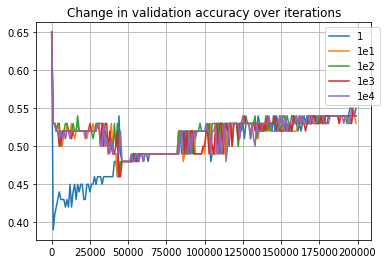

In [ ]:
# Create plot
length = len(accs_list1[0])
row = list(range(1, length*itv1, itv1))
[plt.plot(row, accs_list1[i]) for i in range(len(accs_list1))]
plt.legend(['1', '1e1', '1e2', '1e3', '1e4'], bbox_to_anchor=(1.04,1))
plt.grid()
plt.title("Change in validation accuracy over iterations")
#plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/lrs_compare_max_itrs=2e5.png', bbox_inches="tight")

#### Test learning rates below 0.2

Try the following learning rates: [0.2, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

In [ ]:
# configuration
max_iter = 1e6
itv = int(1e3)
lr_list = [0.2, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
# parallerize training
accs_list = Parallel(n_jobs=-1, verbose=10)(delayed(get_acc_list)(i, max_iter, itv) for i in lr_list)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed: 23.6min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 31.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 31.3min finished


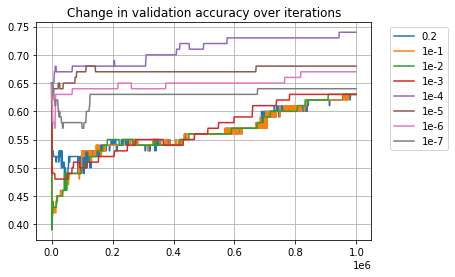

In [ ]:
# Create plot
length = len(accs_list[0])
row = list(range(1, length*itv, itv))
[plt.plot(row, accs_list[i]) for i in range(len(accs_list))]
plt.legend(['0.2', '1e-1', '1e-2', '1e-3', '1e-4', '1e-5', '1e-6', '1e-7'],
           bbox_to_anchor=(1.04,1))
plt.grid()
plt.title("Change in validation accuracy over iterations")
#plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/lrs_compare_max_itrs=1e6.png', bbox_inches="tight")

Now, increase the max_iters and try again with [1e-4, 1e-5, 1e-6, 1e-7].

In [ ]:
# configuration
new_max_iter = 3*(1e6)
new_itv = int(1e4)
new_lr_list = [1e-4, 1e-5, 1e-6, 1e-7]
new_accs_list = []
for i in range(len(new_lr_list)):
    result = get_acc_list(new_lr_list[i], new_max_iter, new_itv)
    print('\n')
    new_accs_list.append(result)

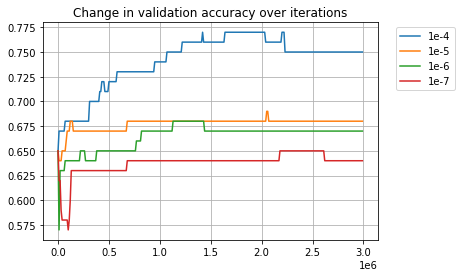

In [ ]:
# Create plot
new_length = len(new_accs_list[0])
new_row = list(range(0, new_length*new_itv, new_itv))
[plt.plot(new_row, new_accs_list[i]) for i in range(len(new_accs_list))]
plt.legend(['1e-4', '1e-5', '1e-6', '1e-7'],
           bbox_to_anchor=(1.04,1))
plt.grid()
plt.title("Change in validation accuracy over iterations")
#plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/lrs_compare_max_itrs=3_1e6.png',
            bbox_inches="tight")

### Base Configuration
From the plot above, the best configuration we found is:
* max_iters = 1.8e6
* lr = 1e-4

However, to ease later trainings, we'll use:
* **max_iters = 2e4**
* **lr = 1e-4**

as our base configuration.


---------------------------
epsilon=1e-4 (default value) but the norm of the gradient didn't decrease below 1e-4 in my experiments, so this parameter is not tuned.

### part 1-2 Mini-batch Stochastic Gradient Descent

### Helper methods and variables

In [ ]:
batch_sizes = [8, 16, 32, 64, 128, 256, 512]

# function to create and fit LR model and receive training info
def get_training_results_batch(lr, max_iters, itv, batch_size, max_epochs, momentum, smoothing):
    model = LogisticRegression(verbose=True, learning_rate=lr, max_iters=max_iters)
    return model.fit_for_vis_complex2(diabetes_train_X, diabetes_train_y, diabetes_val_X, diabetes_val_y, itv, batch_size, max_epochs, momentum)

# helper function to have all time lists be the same length
def same_length_lsts(results):
    max_time_num_itv = 0
    for r in results:
        if len(r.acc_list_time) > max_time_num_itv:
            max_time_num_itv = len(r.acc_list_time)
    for r in results:
        if len(r.acc_list_time) < max_time_num_itv:
            r.acc_list_time += [r.acc_list_time[-1]] * (max_time_num_itv - len(r.acc_list_time))
        if len(r.grad_list_time) < max_time_num_itv:
            r.grad_list_time += [r.grad_list_time[-1]] * (max_time_num_itv - len(r.grad_list_time))
    return results

# method to plot the epochs results
def plot_epochs(results, num_epochs):
    epoch_row = list(range(1, num_epochs + 1))
    [plt.plot(epoch_row, results[i].acc_list_epoch) for i in range(len(results))]
    plt.legend(batch_sizes, bbox_to_anchor=(1.04, 1))
    plt.grid()
    plt.title(f"Change in validation accuracy over iterations by batch size (lr = {learning_rate})")
    plt.savefig('./' + num_epochs + '_acc_epoch_batch')
    
# method to plot the epochs results
def plot_epochs_smooth(results, num_epochs, itv):
    epoch_row = list(range(1, len(results[0].acc_list_epoch)*itv, itv))
    [plt.plot(epoch_row, results[i].acc_list_epoch) for i in range(len(results))]
    plt.legend(batch_sizes, bbox_to_anchor=(1.04, 1))
    plt.grid()
    plt.title(f"Change in validation accuracy over epochs by batch size (lr = {str(results[0].lr_model.learning_rate)})")
    plt.savefig('./' + num_epochs + '_acc_epoch_batch')
    
# method to plot all other results
def plot_results(results, lr_val):
    length = len(results[0].acc_list_it)
    it_row = list(range(1, length*itv, itv))
    time_row = list(range(0, 15*len(results[0].acc_list_time), 15))
    learning_rate = results[0].lr_model.learning_rate
    
    [plt.plot(it_row, results[i].acc_list_it) for i in range(len(results))]
    plt.legend(batch_sizes, bbox_to_anchor=(1.04, 1))
    plt.grid()
    plt.title(f"Change in validation accuracy over iterations by batch size (lr = {learning_rate})")
    plt.savefig('./' + lr_val + '_acc_iter_batch')

    
    [plt.plot(time_row, results[i].acc_list_time) for i in range(len(results))]
    plt.legend(batch_sizes, bbox_to_anchor=(1.04, 1))
    plt.grid()
    plt.title(f"Speed of accuracy convergence by batch size (lr = {learning_rate})")
    plt.savefig('./figures/' + lr_val + '_acc_speed_batch')


    [plt.plot(it_row, results[i].grad_list_it) for i in range(len(results))]
    plt.legend(batch_sizes, bbox_to_anchor=(1.04, 1))
    plt.grid()
    plt.title(f"Change in gradient over iterations by batch size (lr = {learning_rate})")
    plt.savefig('./figures/' + lr_val + '_grad_iter_batch')

    
    [plt.plot(time_row, results[i].grad_list_time) for i in range(len(results))]
    plt.legend(batch_sizes, bbox_to_anchor=(1.04, 1))
    plt.grid()
    plt.title(f"Speed of gradient convergence by batch size (lr = {learning_rate})")
    plt.savefig('./figures/' + lr_val + '_grad_speed_batch')

### Train (by epochs) with all batch sizes

In [ ]:
# base configuration
itv = int(2e2)
lr = 1e-4
max_epochs = 2e4

results_batch_lr_1e4 = [ get_training_results_batch(lr, 3*(1e6), itv, batch_size, max_epochs, 0, True) for batch_size in batch_sizes]

(600, 9)
1000/20000.0 complete.
2000/20000.0 complete.
3000/20000.0 complete.
4000/20000.0 complete.
5000/20000.0 complete.
6000/20000.0 complete.
7000/20000.0 complete.
8000/20000.0 complete.
9000/20000.0 complete.
10000/20000.0 complete.
11000/20000.0 complete.
12000/20000.0 complete.
13000/20000.0 complete.
14000/20000.0 complete.
15000/20000.0 complete.
16000/20000.0 complete.
17000/20000.0 complete.
18000/20000.0 complete.
19000/20000.0 complete.
20000/20000.0 complete.
learning rate: 0.0001
batch size: 8
terminated after 1500000 iterations, with norm of the gradient equal to 51.4645491757488
the weight found: [ 1.35935207e-01  2.33963761e-02 -2.06957086e-02 -1.79481478e-03
  1.68774878e-03  3.32513366e-02  4.88255199e-01 -7.69824505e-04
 -3.79615214e+00]
time elapsed:  402.76 seconds

(600, 9)
1000/20000.0 complete.
2000/20000.0 complete.
3000/20000.0 complete.
4000/20000.0 complete.
5000/20000.0 complete.
6000/20000.0 complete.
7000/20000.0 complete.
8000/20000.0 complete.
9000/

In [ ]:
# base configuration
itv = int(2e3)
lr = 1e-4
max_epochs = 2e4

results_batch_lr_1e4_smaller_itv = [ get_training_results_batch(lr, 3*(1e6), itv, batch_size, max_epochs, 0, True) for batch_size in batch_sizes]

(600, 9)
1000/20000.0 complete.
2000/20000.0 complete.
3000/20000.0 complete.
4000/20000.0 complete.
5000/20000.0 complete.
6000/20000.0 complete.
7000/20000.0 complete.
8000/20000.0 complete.
9000/20000.0 complete.
10000/20000.0 complete.
11000/20000.0 complete.
12000/20000.0 complete.
13000/20000.0 complete.
14000/20000.0 complete.
15000/20000.0 complete.
16000/20000.0 complete.
17000/20000.0 complete.
18000/20000.0 complete.
19000/20000.0 complete.
20000/20000.0 complete.
learning rate: 0.0001
batch size: 8
terminated after 1500000 iterations, with norm of the gradient equal to 42.853071430078714
the weight found: [ 1.36277936e-01  2.73105649e-02 -1.92947905e-02 -1.60275301e-03
  3.25387120e-03  3.35983864e-02  4.88646561e-01 -1.14290132e-03
 -3.79659160e+00]
time elapsed:  409.16 seconds

(600, 9)
1000/20000.0 complete.
2000/20000.0 complete.
3000/20000.0 complete.
4000/20000.0 complete.
5000/20000.0 complete.
6000/20000.0 complete.
7000/20000.0 complete.
8000/20000.0 complete.
900

In [ ]:
# base configuration
itv = int(2e4)
lr = 1e-4
max_epochs = 2e5

results_batch_2e5_epochs = [ get_training_results_batch(lr, 3*(1e6), itv, batch_size, max_epochs, 0, True) for batch_size in batch_sizes]

(600, 9)
1000/200000.0 complete.
2000/200000.0 complete.
3000/200000.0 complete.
4000/200000.0 complete.
5000/200000.0 complete.
6000/200000.0 complete.
7000/200000.0 complete.
8000/200000.0 complete.
9000/200000.0 complete.
10000/200000.0 complete.
11000/200000.0 complete.
12000/200000.0 complete.
13000/200000.0 complete.
14000/200000.0 complete.
15000/200000.0 complete.
16000/200000.0 complete.
17000/200000.0 complete.
18000/200000.0 complete.
19000/200000.0 complete.
20000/200000.0 complete.
21000/200000.0 complete.
22000/200000.0 complete.
23000/200000.0 complete.
24000/200000.0 complete.
25000/200000.0 complete.
26000/200000.0 complete.
27000/200000.0 complete.
28000/200000.0 complete.
29000/200000.0 complete.
30000/200000.0 complete.
31000/200000.0 complete.
32000/200000.0 complete.
33000/200000.0 complete.
34000/200000.0 complete.
35000/200000.0 complete.
36000/200000.0 complete.
37000/200000.0 complete.
38000/200000.0 complete.
39000/200000.0 complete.
40000/200000.0 complete.


112000/200000.0 complete.
113000/200000.0 complete.
114000/200000.0 complete.
115000/200000.0 complete.
116000/200000.0 complete.
117000/200000.0 complete.
118000/200000.0 complete.
119000/200000.0 complete.
120000/200000.0 complete.
121000/200000.0 complete.
122000/200000.0 complete.
123000/200000.0 complete.
124000/200000.0 complete.
125000/200000.0 complete.
126000/200000.0 complete.
127000/200000.0 complete.
128000/200000.0 complete.
129000/200000.0 complete.
130000/200000.0 complete.
131000/200000.0 complete.
132000/200000.0 complete.
133000/200000.0 complete.
134000/200000.0 complete.
135000/200000.0 complete.
136000/200000.0 complete.
137000/200000.0 complete.
138000/200000.0 complete.
139000/200000.0 complete.
140000/200000.0 complete.
141000/200000.0 complete.
142000/200000.0 complete.
143000/200000.0 complete.
144000/200000.0 complete.
145000/200000.0 complete.
146000/200000.0 complete.
147000/200000.0 complete.
148000/200000.0 complete.
149000/200000.0 complete.
150000/20000

6000/200000.0 complete.
7000/200000.0 complete.
8000/200000.0 complete.
9000/200000.0 complete.
10000/200000.0 complete.
11000/200000.0 complete.
12000/200000.0 complete.
13000/200000.0 complete.
14000/200000.0 complete.
15000/200000.0 complete.
16000/200000.0 complete.
17000/200000.0 complete.
18000/200000.0 complete.
19000/200000.0 complete.
20000/200000.0 complete.
21000/200000.0 complete.
22000/200000.0 complete.
23000/200000.0 complete.
24000/200000.0 complete.
25000/200000.0 complete.
26000/200000.0 complete.
27000/200000.0 complete.
28000/200000.0 complete.
29000/200000.0 complete.
30000/200000.0 complete.
31000/200000.0 complete.
32000/200000.0 complete.
33000/200000.0 complete.
34000/200000.0 complete.
35000/200000.0 complete.
36000/200000.0 complete.
37000/200000.0 complete.
38000/200000.0 complete.
39000/200000.0 complete.
40000/200000.0 complete.
41000/200000.0 complete.
42000/200000.0 complete.
43000/200000.0 complete.
44000/200000.0 complete.
45000/200000.0 complete.
4600

117000/200000.0 complete.
118000/200000.0 complete.
119000/200000.0 complete.
120000/200000.0 complete.
121000/200000.0 complete.
122000/200000.0 complete.
123000/200000.0 complete.
124000/200000.0 complete.
125000/200000.0 complete.
126000/200000.0 complete.
127000/200000.0 complete.
128000/200000.0 complete.
129000/200000.0 complete.
130000/200000.0 complete.
131000/200000.0 complete.
132000/200000.0 complete.
133000/200000.0 complete.
134000/200000.0 complete.
135000/200000.0 complete.
136000/200000.0 complete.
137000/200000.0 complete.
138000/200000.0 complete.
139000/200000.0 complete.
140000/200000.0 complete.
141000/200000.0 complete.
142000/200000.0 complete.
143000/200000.0 complete.
144000/200000.0 complete.
145000/200000.0 complete.
146000/200000.0 complete.
147000/200000.0 complete.
148000/200000.0 complete.
149000/200000.0 complete.
150000/200000.0 complete.
151000/200000.0 complete.
152000/200000.0 complete.
153000/200000.0 complete.
154000/200000.0 complete.
155000/20000

12000/200000.0 complete.
13000/200000.0 complete.
14000/200000.0 complete.
15000/200000.0 complete.
16000/200000.0 complete.
17000/200000.0 complete.
18000/200000.0 complete.
19000/200000.0 complete.
20000/200000.0 complete.
21000/200000.0 complete.
22000/200000.0 complete.
23000/200000.0 complete.
24000/200000.0 complete.
25000/200000.0 complete.
26000/200000.0 complete.
27000/200000.0 complete.
28000/200000.0 complete.
29000/200000.0 complete.
30000/200000.0 complete.
31000/200000.0 complete.
32000/200000.0 complete.
33000/200000.0 complete.
34000/200000.0 complete.
35000/200000.0 complete.
36000/200000.0 complete.
37000/200000.0 complete.
38000/200000.0 complete.
39000/200000.0 complete.
40000/200000.0 complete.
41000/200000.0 complete.
42000/200000.0 complete.
43000/200000.0 complete.
44000/200000.0 complete.
45000/200000.0 complete.
46000/200000.0 complete.
47000/200000.0 complete.
48000/200000.0 complete.
49000/200000.0 complete.
50000/200000.0 complete.
51000/200000.0 complete.


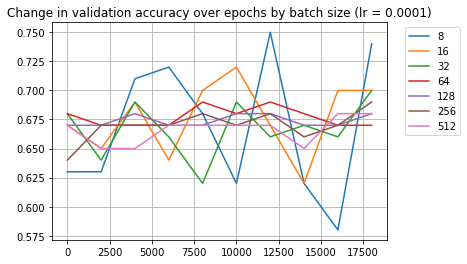

In [ ]:
plot_epochs_smooth(results_batch_lr_1e4_smaller_itv, '2e4_smooth', int(2e3))

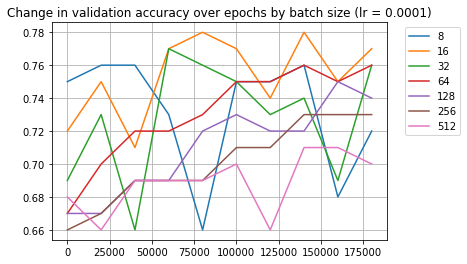

In [ ]:
plot_epochs_smooth(results_batch_2e5_epochs, '2e5_smooth', int(2e4))

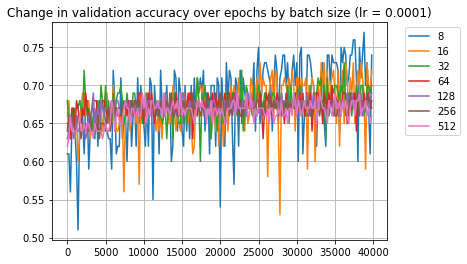

In [ ]:
plot_epochs_smooth(results_batch_lr_1e4, '2e4', int(2e2))

In [ ]:
for result in results_batch_2e5_epochs:
    print(f'Batch size: {result.batch_size}  Accuracy: {get_test_acc(result, diabetes_test_X, diabetes_test_y)}')
    print(f'Batch size: {result.batch_size}  Len Acc Epoch: {len(result.acc_list_epoch)}')

Batch size: 8  Accuracy: 0.7647058823529411
Batch size: 8  Len Acc Epoch: 10
Batch size: 16  Accuracy: 0.7647058823529411
Batch size: 16  Len Acc Epoch: 10
Batch size: 32  Accuracy: 0.7794117647058824
Batch size: 32  Len Acc Epoch: 10
Batch size: 64  Accuracy: 0.7647058823529411
Batch size: 64  Len Acc Epoch: 10
Batch size: 128  Accuracy: 0.7794117647058824
Batch size: 128  Len Acc Epoch: 10
Batch size: 256  Accuracy: 0.7352941176470589
Batch size: 256  Len Acc Epoch: 10
Batch size: 512  Accuracy: 0.7058823529411765
Batch size: 512  Len Acc Epoch: 10


### part 1-3 Momentum

In [ ]:
def get_result(lr, max_iters=2e4, itv=1e2,
               batch_size=-1, max_epochs=-1, momentum=0, smoothing=False):
    model = LogisticRegression(verbose=True, learning_rate=lr, max_iters=max_iters)
    result = model.fit_for_vis_complex2(diabetes_train_X, diabetes_train_y, diabetes_val_X, diabetes_val_y,
                                       itv, batch_size, max_epochs, momentum, smoothing)
    return result

def get_test_acc(result, test_X, test_y):
    model = result.lr_model
    test_yh = (model.predict(test_X) > 0.5).astype('int')
    return accuracy_score(test_y, test_yh)

In [ ]:
# base configuration
itv = int(1e2)
lr = 1e-4
max_iters = 2e4

####Convergence speed in batch gradient descent

In [ ]:
%%time
full_batch_result = get_result(lr, max_epochs=max_iters, itv=itv, momentum=0)
full_batch_grad = full_batch_result.grad_list_epoch

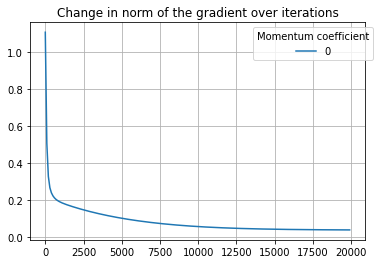

In [ ]:
# Create plot
length = len(full_batch_grad)
row = list(range(1, length*itv, itv))
plt.plot(row, full_batch_grad)
plt.legend(['0'], bbox_to_anchor=(1.04,1),
           title='Momentum coefficient')
plt.grid()
plt.title("Change in norm of the gradient over iterations")
#plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/1_3_batch_grad.png', bbox_inches="tight")
plt.show()

#### Try different momentum coefficients

In [ ]:
%%time
# Momentum added to LogisticRegression.py fit_for_vis_complex function
# base configuration
itv = int(1e2)
lr = 1e-4
max_iters = 2e4
coeffs = [0, 0.2, 0.5, 0.7, 0.9, 0.99]
momentum_results = Parallel(n_jobs=-1, verbose=10)(delayed(get_result)(lr, max_iters, itv, momentum=coeff) for coeff in coeffs)
momentum_grads = [r.grad_list_it for r in momentum_results]
momentum_accs = [r.acc_list_it for r in momentum_results]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   21.3s remaining:   10.7s


CPU times: user 209 ms, sys: 38.5 ms, total: 247 ms
Wall time: 31.2 s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   31.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   31.2s finished


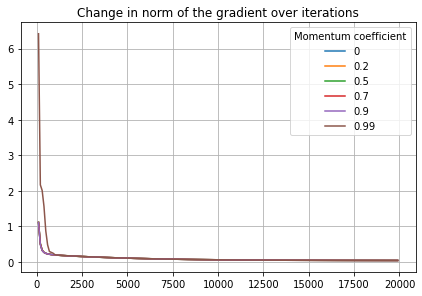

In [ ]:
# Create plot
my_list = momentum_grads
length = len(my_list[0])
row = list(range(1, length*itv, itv))
[plt.plot(row, my_list[i]) for i in range(len(my_list))]
plt.legend(['0', '0.2', '0.5', '0.7', '0.9', '0.99'],
           title='Momentum coefficient')
plt.grid()
plt.tight_layout()
plt.title("Change in norm of the gradient over iterations")
#plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/1_3_mom_grads.png')

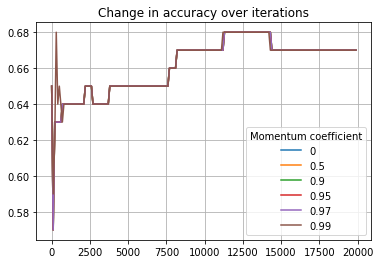

In [ ]:
# Create plot
my_list = momentum_accs
length = len(my_list[0])
row = list(range(1, length*itv, itv))
[plt.plot(row, my_list[i]) for i in range(len(my_list))]
plt.legend(['0', '0.5', '0.9', '0.95', '0.97', '0.99'],
           title='Momentum coefficient')
plt.grid()
plt.title("Change in accuracy over iterations")
#plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/1_3_mom_accs.png')

### part 1-4 Experiment momentum with mini-batch SGD
repeat the previous step for a) the smallest batch size and b) largest batch size you tried in 2). In which setting (small mini-batch, large mini-batch, fully batched) is it the most / least effective ?

####Smallest mini-batch: `batch_size`=8

In [ ]:
import random
import joblib

In [ ]:
%%time
# Momentum added to LogisticRegression.py fit_for_vis_complex function
# base configuration
itv = int(1e2)
lr = 1e-4
max_iters = 2e4
coeffs = [0, 0.2, 0.5, 0.7, 0.9, 0.99]
mini_small_results = Parallel(n_jobs=-1, verbose=10)(delayed(get_result)(lr,max_iters, itv,
                                                                       batch_size=8, max_epochs=max_iters, momentum=coeff, smoothing=True) for coeff in coeffs)
joblib.dump(mini_small_results, '/content/drive/MyDrive/COMP551/mini2/objects/mini_small_smooth_results.pkl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed: 20.5min remaining: 10.3min


CPU times: user 6.81 s, sys: 842 ms, total: 7.65 s
Wall time: 30min 40s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 30.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 30.7min finished


In [ ]:
[get_test_acc(result, diabetes_test_X, diabetes_test_y) for result in mini_small_results]

[0.7058823529411765,
 0.75,
 0.7205882352941176,
 0.7352941176470589,
 0.8088235294117647,
 0.7352941176470589]

In [ ]:
def save_plot(input_result, lr, grad=True, bs='bs8'):
    # Create plot
    if grad:
        my_list = input_result.grad_list_epoch
        plt_title = 'norm of the gradient'
        file_title = 'grad'
    else:
        my_list = input_result.acc_list_epoch
        plt_title = 'accuracy'
        file_title = 'acc'
    length = len(my_list)
    row = list(range(1, length*itv, itv))
    plt.plot(row, my_list)
    plt.legend([str(lr)], bbox_to_anchor=(1.04,1),
            title='Momentum coefficient')
    plt.grid()
    plt.title("Change in " + plt_title + " over epochs")
    plt.savefig(f"{'/content/drive/MyDrive/COMP551/mini2/figures/1_3_' + bs + '_mini_' + file_title + '_coeff0'+ str(int(lr*100)) + '.png'}", bbox_inches="tight")
    plt.show()


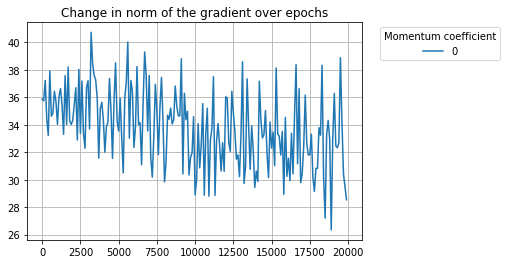

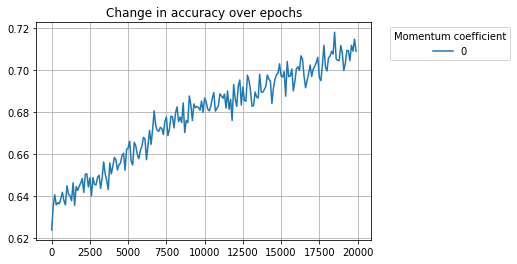

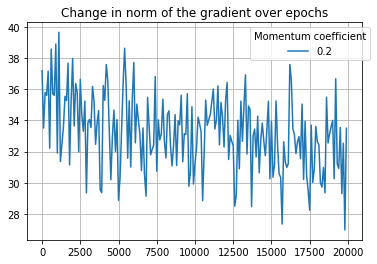

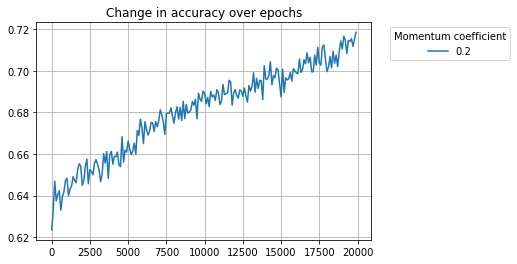

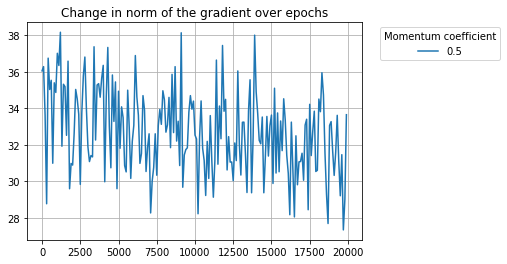

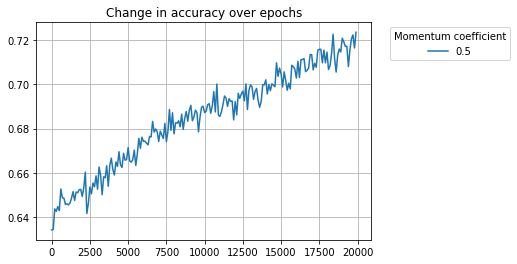

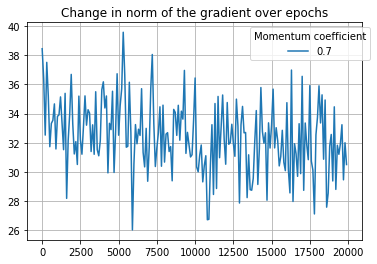

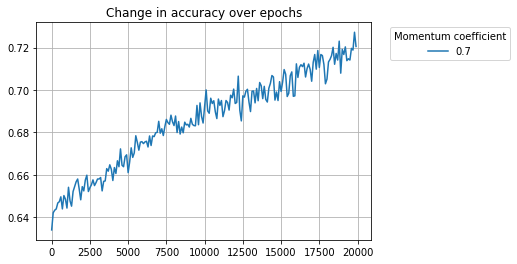

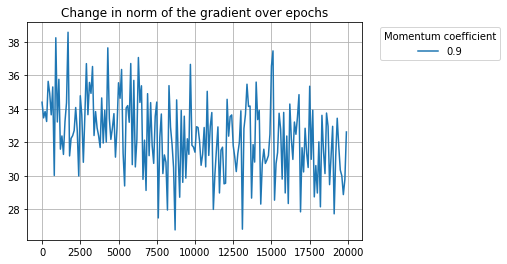

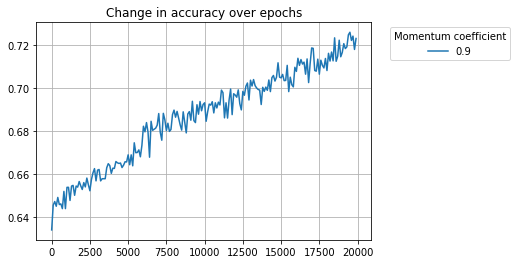

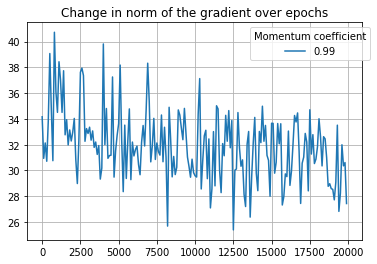

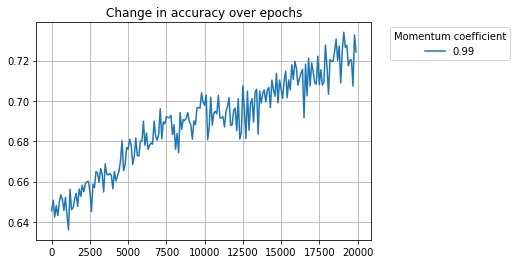

In [ ]:
for result, lr in zip(mini_small_results, [0, 0.2, 0.5, 0.7, 0.9, 0.99]):
    save_plot(result, lr, grad=True, bs='bs8_smooth')
    save_plot(result, lr, grad=False, bs='bs8_smooth')

####Largest mini-batch: `batch_size`=512

In [ ]:
%%time
# Momentum added to LogisticRegression.py fit_for_vis_complex function
# base configuration
itv = int(1e2)
lr = 1e-4
max_iters = 2e4
coeffs = [0, 0.2, 0.5, 0.7, 0.9, 0.99]
mini_large_results = Parallel(n_jobs=-1, verbose=10)(delayed(get_result)(lr,max_iters, itv,
                                                                       batch_size=512, max_epochs=max_iters,
                                                                       momentum=coeff, smoothing=True) for coeff in coeffs)
joblib.dump(mini_large_results, '/content/drive/MyDrive/COMP551/mini2/objects/mini_large_smooth_results.pkl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.4min remaining:   41.2s


CPU times: user 502 ms, sys: 66.6 ms, total: 569 ms
Wall time: 2min 3s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.1min finished


In [ ]:
[get_test_acc(result, diabetes_test_X, diabetes_test_y) for result in mini_large_results]

[0.7205882352941176,
 0.7205882352941176,
 0.7058823529411765,
 0.7058823529411765,
 0.6911764705882353,
 0.7205882352941176]

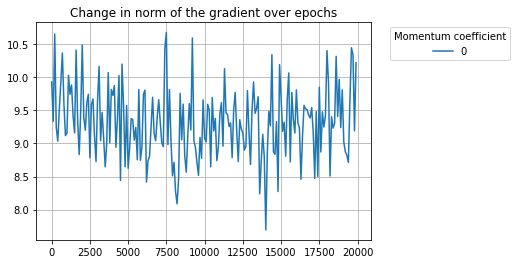

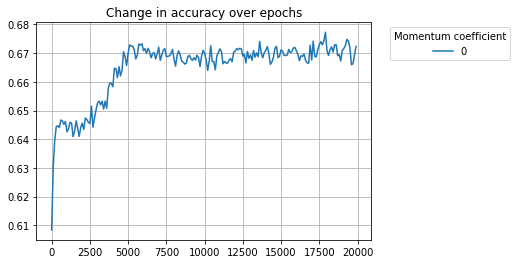

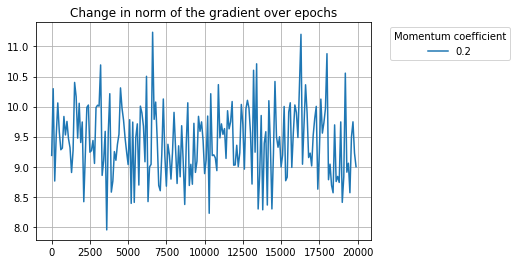

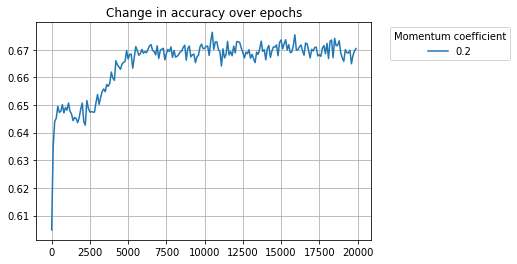

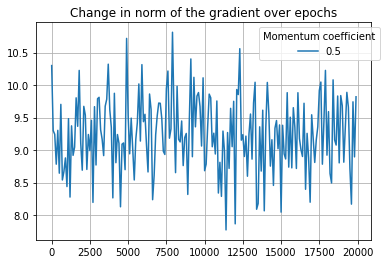

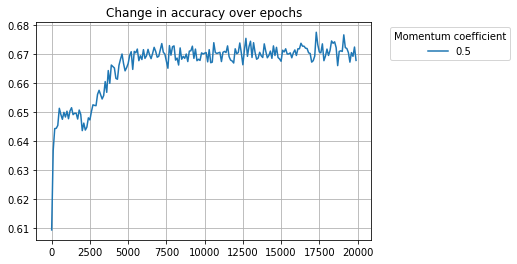

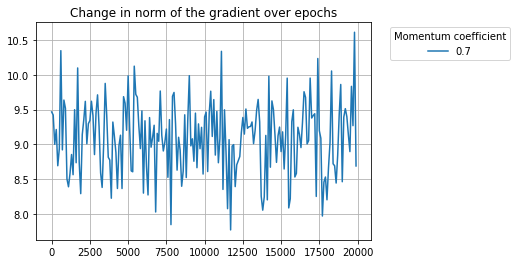

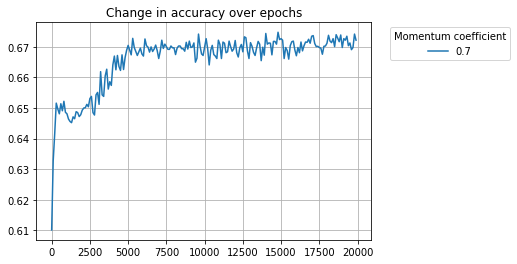

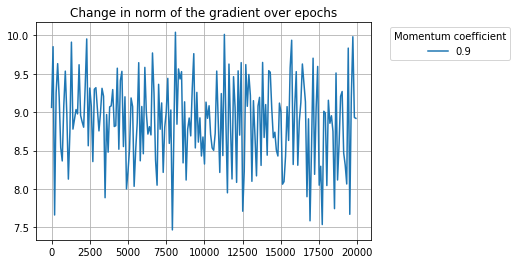

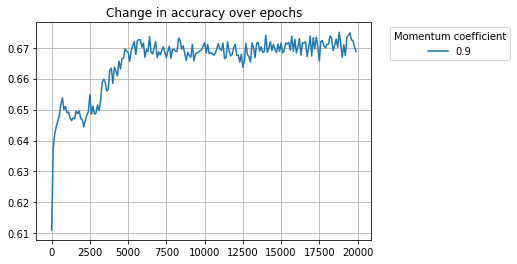

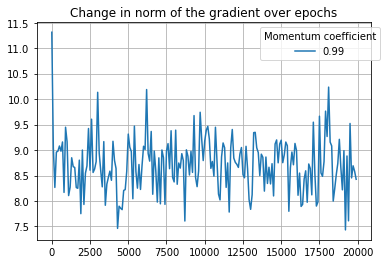

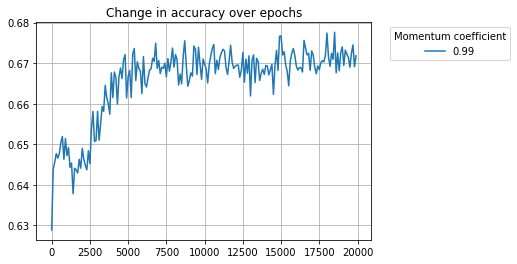

In [ ]:
for result, lr in zip(mini_large_results, [0, 0.2, 0.5, 0.7, 0.9, 0.99]):
    save_plot(result, lr, grad=True, bs='bs512_smooth')
    save_plot(result, lr, grad=False, bs='bs512_smooth')

###Batch gradient descent (lr=1e3)





In [ ]:
%%time
# Momentum added to LogisticRegression.py fit_for_vis_complex function
# base configuration
itv = int(1e2)
lr = 1e3
max_iters = 2e4
coeffs = [0, 0.2, 0.5, 0.7, 0.9, 0.99]
full_results = Parallel(n_jobs=-1, verbose=10)(delayed(get_result)(lr,max_iters, itv,
                                                                       batch_size=600, max_epochs=max_iters, momentum=coeff, smoothing=True) for coeff in coeffs)
joblib.dump(mini_small_results, '/content/drive/MyDrive/COMP551/mini2/objects/lr1e3_batch_results.pkl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.1min remaining:   34.1s


CPU times: user 467 ms, sys: 68.6 ms, total: 536 ms
Wall time: 1min 41s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.7min finished


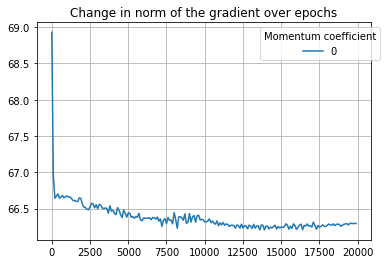

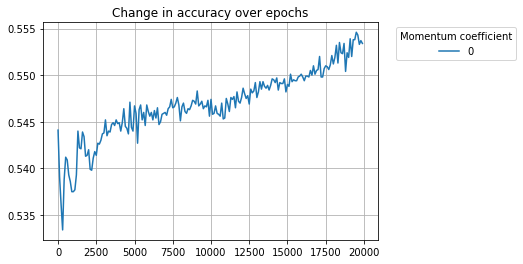

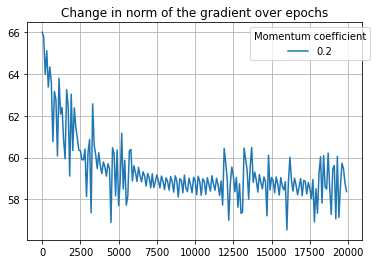

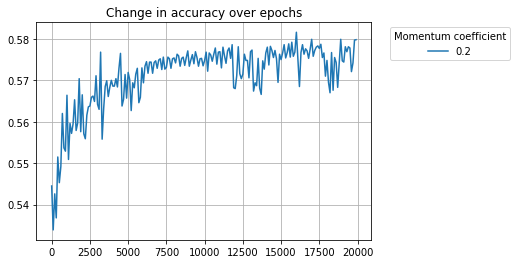

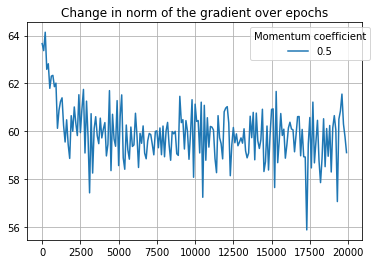

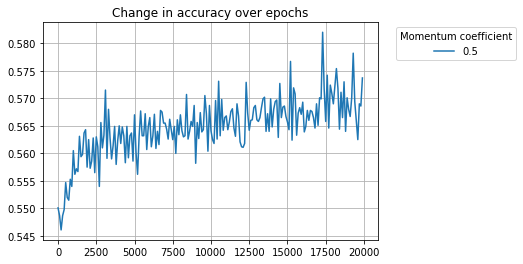

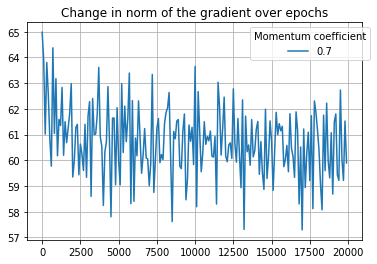

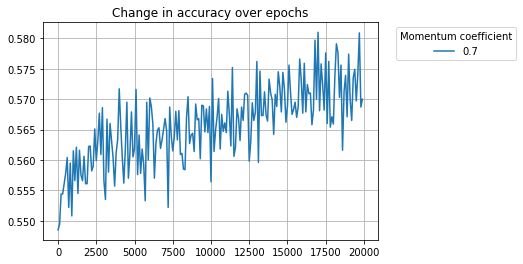

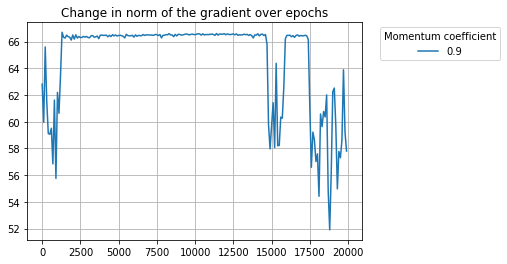

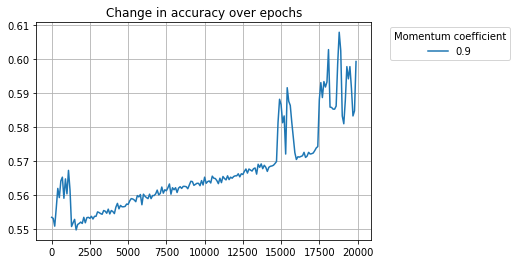

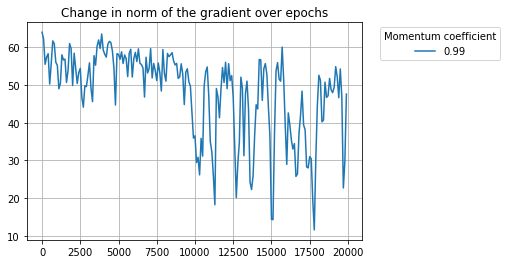

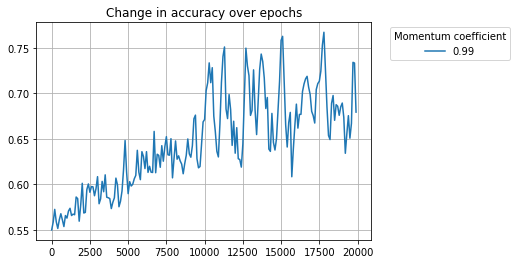

In [ ]:
for result, lr in zip(full_results, [0, 0.2, 0.5, 0.7, 0.9, 0.99]):
    save_plot(result, lr, grad=True, bs='lr1e3_full')
    save_plot(result, lr, grad=False, bs='lr1e3_full')

## **Part 2: Text Classification**
Link to datasets: https://github.com/felixsimard/comp551-p2/tree/main/fake_news


In [14]:
# Define constants

# Contractions dictonary
# Reference: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions_dict = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
# Regular expression for finding contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('http')

In [15]:
# Define dataset paths
fake_new_train_dir = r'fake_news/fake_news_train.csv'
fake_news_val_dir = r'fake_news/fake_news_val.csv'
fake_news_test_dir = r'fake_news/fake_news_test.csv'

# Load datasets
fake_news_train = pd.read_csv(fake_new_train_dir, engine="python", error_bad_lines=False)
fake_news_val = pd.read_csv(fake_news_val_dir, engine="python", error_bad_lines=False)
fake_news_test = pd.read_csv(fake_news_test_dir, engine="python", error_bad_lines=False)

fake_news_train

Skipping line 8880: unexpected end of data
Skipping line 2657: unexpected end of data


,text,label
0,Indian fruit is so important to so many people...,0
1,"FORT WORTH, Texas — Urú Inc. will hold a confe...",0
2,"With three of the four new carriers, the Niger...",0
3,Let's start with the classic annual dividend r...,0
4,Following are some of the major events to have...,1
...,...,...
8873,A teen accused of killing his mother escaped j...,1
8874,"× Diabetes drug has heart and kidney benefits,...",1
8875,× Indiana Senate passes their version of state...,1
8876,A man was arrested after he was accused of thr...,0


#### Quick dataset scan

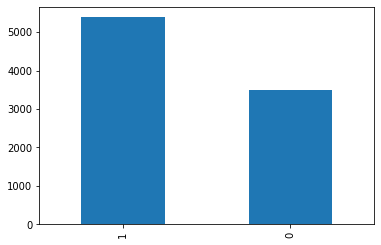

In [16]:
# Look at label value distribution and save ratios for Logitic Regression class weights
train_value_counts = fake_news_train.label.value_counts()
total = train_value_counts[0] + train_value_counts[1]
train_labels_ratio = {
    0: train_value_counts[0] / total,
    1: train_value_counts[1] / total,
}

train_value_counts.plot(kind='bar')

#### Preprocessing

In [17]:
# Stemmer function
def apply_stemmer(text):
    stemmer= PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

# Expanding contractions
# Reference: https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Remove stop-words
# Reference: https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
        
# Preprocessing function
def preprocess(df):

    # Lowercase everything
    df['text'] = df['text'].str.lower()

    # Expand contractions
    # Reference: https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
    df['text'] = df['text'].apply(lambda x : expand_contractions(x))

    # Remove ponctuation
    df['text'] = df['text'].replace(r'[^\w\s]', r'', regex=True)

    # Remove numbers
    df['text'] = df['text'].replace(r'\d', r'', regex=True)

    # Remove special characters (eg: \n)
    df['text'] = df['text'].replace(r'\\[a-z]', r'', regex=True)

    # Remove stop words
    df['text'] = df['text'].apply(lambda x : remove_stopwords(x))

    # Stemming - not helping generalization...
    # df["text"] = df["text"].apply(lambda x: apply_stemmer(x))

    # Trim whitespaces
    df['text'] = df['text'].str.strip()

    # Word level count vectorization
    vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', min_df=5, max_df=0.5, max_features=20000, binary=True)
    X_train_counts = vect.fit_transform(df.text)
    joblib.dump(vect, "vectorizer.pkl")
    print("Vectorizer vocabulary:", vect.vocabulary_.get(u'algorithm'))
    print("Count Vectorizer shape:", X_train_counts.shape)
    

    # TF-IDF representation using bag-of-words matrix
    tfidf_transform = TfidfTransformer()
    X_train_tfidf = tfidf_transform.fit_transform(X_train_counts)
    joblib.dump(tfidf_transform, "tfidf_transform.pkl")
    print("TF-IDF shape:", X_train_tfidf.shape)
    print("\n")

    return X_train_tfidf, df

def transform_preprocess(x_test):
    # Load saved pickles
    loaded_vectorizer = joblib.load("vectorizer.pkl")
    loaded_tfidf_transform = joblib.load("tfidf_transform.pkl")
    # loaded_model = joblib.load("model.pkl")

    # Transform
    x_val_vec = loaded_vectorizer.transform(x_test)
    x_val_tfidf = loaded_tfidf_transform.transform(x_val_vec)

    return x_val_tfidf

#### Model Training, Validation, Testing

In [18]:
# Cross Validation and Hyper-parameter tuning

# Grid Search cross validation
param_grid = [
          {'C': [1, 5, 10], 'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'solver': ['newton-cg', 'liblinear', 'lbfgs'], 'tol': [0.0001, 0.001, 0.01, 0.1], 'max_iter': [200, 500, 1000]}
]

# Pre-process training data
X_train_preprocessed_tfidf, X_train_preprocessed  = preprocess(fake_news_train)
y_train = fake_news_train['label']

# Pre-process validation data
X_val_preprocessed_tfidf = transform_preprocess(fake_news_val['text'])
y_val = fake_news_val['label']

# Pre-process testing data
X_test_preprocessed_tfidf = transform_preprocess(fake_news_test['text'])
y_test = fake_news_test['label']

# Grid-search all parameter combinations using a validation set.
opt = GridSearch(model = LogisticRegression(), param_grid = param_grid)
opt.fit(X_train_preprocessed_tfidf, y_train, X_val_preprocessed_tfidf, y_val)
print('Test Score for Optimized Parameters:', opt.score(X_test_preprocessed_tfidf, y_test))
print(opt.get_best_params)

Vectorizer vocabulary: 505
Count Vectorizer shape: (8878, 20000)
TF-IDF shape: (8878, 20000)




/usr/local/lib/python3.7/dist-packages/hypopt/model_selection.py:174: UserWarning: ERROR in thread<NoDaemonProcess(NoDaemonPoolWorker-3, started)>with exception:
Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
  warnings.warn('ERROR in thread' + pname + "with exception:\n" + str(e))
/usr/local/lib/python3.7/dist-packages/hypopt/model_selection.py:174: UserWarning: ERROR in thread<NoDaemonProcess(NoDaemonPoolWorker-4, started)>with exception:
Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
  warnings.warn('ERROR in thread' + pname + "with exception:\n" + str(e))
  1%|          | 5/432 [00:00<00:41, 10.30it/s]/usr/local/lib/python3.7/dist-packages/hypopt/model_selection.py:174: UserWarning: ERROR in thread<NoDaemonProcess(NoDaemonPoolWorker-4, started)>with exception:
Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
  warnings.warn('ERROR in thread' + pname + "with exception:\n" + str(e))
  5%|▍         | 21/432 [00:07

Test Score for Optimized Parameters: 0.6971751412429379
<bound method GridSearch.get_best_params of GridSearch(cv_folds=3,
           model=LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=200,
                                    multi_class='auto', n_jobs=None,
                                    penalty='none', random_state=0,
                                    solver='lbfgs', tol=0.1, verbose=0,
                                    warm_start=False),
           num_threads=2, parallelize=True,
           param_grid=[{'C': [1, 5, 10], 'max_iter': [200, 500, 1000],
                        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                        'solver': ['newton-cg', 'liblinear', 'lbfgs'],
                        'tol': [0.0001, 0.001, 0.01, 0.1]}],
           seed=0)>


In [19]:
def train_model(x_train, y_train, params={}):
    # preprocess x_train
    x_train_preprocessed_tfidf, x_train_preprocessed  = preprocess(x_train)

    # fit model
    model = LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=200,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='none', random_state=0,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False)
    trained = model.fit(x_train_preprocessed_tfidf, y_train)
    training_score = trained.score(x_train_preprocessed_tfidf, y_train)
    joblib.dump(trained, "model.pkl")

    print("Training score:", training_score)

    return trained

In [20]:
# Train model
trained_model = train_model(fake_news_train, fake_news_train['label'])

Vectorizer vocabulary: 505
Count Vectorizer shape: (8878, 20000)
TF-IDF shape: (8878, 20000)


Training score: 1.0


In [21]:

# Test set
x_test_tfidf = transform_preprocess(fake_news_test['text'])
y_predictions = trained_model.predict(x_test_tfidf)

acc_score = accuracy_score(fake_news_test['label'], y_predictions)
print("Accuracy on test set:", acc_score)

Accuracy on test set: 0.6990583804143126


In [22]:
# Compare to a dummy/random classifier
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

from sklearn.dummy import DummyClassifier

# Initialize random classifier
dummy_clf = DummyClassifier(strategy='uniform')
x_train_dummy_tfidf, x_train_dummy = preprocess(fake_news_train)
dummy_clf.fit(x_train_dummy_tfidf, fake_news_train['label'])

# Apply dummy/random classifier to test set
y_predictions_dummy = dummy_clf.predict(x_test_tfidf)
acc_score_dummy = accuracy_score(fake_news_test['label'], y_predictions_dummy)

print("Random Classifier Accuracy:", acc_score_dummy)

Vectorizer vocabulary: 505
Count Vectorizer shape: (8878, 20000)
TF-IDF shape: (8878, 20000)


Random Classifier Accuracy: 0.5073446327683616
